# Applying `elo-grad` to football data

This notebook provides example usage of the `elo-grad` package for Premier League football data.
We generate predictions for the outcome of games and ratings for the teams 
(actually one for each team's attack and one for each team's defence) over time
using the `PoissonEloEstimator` rating system, 
*i.e.* an Elo rating system based on Poisson regression
(see [Poisson Elo](https://cookepm.github.io/elo-grad/feature_ref/poisson/) for more details).

To install all the dependencies required for this notebook (and any other example notebooks), run `pip install elo-grad[examples]`.

In [1]:
import datetime
import random
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss, mean_poisson_deviance
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from elo_grad import PoissonEloEstimator, Regressor
from elo_grad.sklearn import SKPoissonEloEstimator


print(f'Python {sys.version} on {sys.platform}.')

Python 3.10.11 (main, Dec 16 2023, 21:35:16) [GCC 11.4.0] on linux.


## Getting the data

We use Premier League football data from [538](https://abcnews.go.com/538) under the [Creative Commons Attribution 4.0 License](https://creativecommons.org/licenses/by/4.0/).

**NOTE:** the below will not run on Windows machines. Manually download the CSV if that is the case.

In [ ]:
!bash ! test -f ./data/football_elo.csv && curl https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv -o ./data/football_elo.csv

## Processing the data

In [3]:
df = pd.read_csv(
    './data/football_elo.csv',
    usecols=['league', 'date', 'team1', 'team2', 'score1', 'score2', 'prob1', 'prob2', 'probtie'],
    parse_dates=['date'],
    index_col=['date'],
)
# We only want Premier league data
df = (
    df[df['league'] == 'Barclays Premier League']
    .drop(['league'], axis=1)
)
# Convert dtypes post-filtering
df['score1'] = df['score1'].astype(int)
df['score2'] = df['score2'].astype(int)
df['t'] = (df.index.astype(int) / 1e9).astype(int)
# Assign a game index to keep track of the games
df['game_ix'] = range(df.shape[0])
# Add a result column
df['result'] = np.where(df['score1'] > df['score2'], 'H', np.where(df['score1'] == df['score2'], 'D', 'A'))
print(f'We have {df.shape[0]:,} matches.')
df.head()

We have 2,660 matches.


,team1,team2,prob1,prob2,probtie,score1,score2,t,game_ix,result
date,,,,,,,,,,
2016-08-13,Hull City,Leicester City,0.3459,0.3621,0.2921,2,1,1471046400,0,H
2016-08-13,Everton,Tottenham Hotspur,0.3910,0.3401,0.2689,1,1,1471046400,1,D
2016-08-13,Crystal Palace,West Bromwich Albion,0.4214,0.2939,0.2847,0,1,1471046400,2,A
2016-08-13,Middlesbrough,Stoke City,0.4380,0.2692,0.2927,1,1,1471046400,3,D
2016-08-13,Southampton,Watford,0.5759,0.1874,0.2367,1,1,1471046400,4,D


Quick check for nulls.

In [4]:
df.isnull().sum()

team1      0
team2      0
prob1      0
prob2      0
probtie    0
score1     0
score2     0
t          0
game_ix    0
result     0
dtype: int64

Create two rows per game - one for the number of goals scored by each team.

We also create two entities per team - an attack entity and a defence entity.
They will have independent ratings when we build our Poisson Elo rating system.

In [5]:
home_df = (
    df
    .rename(
        columns={
            'team1': 'team',
            'team2': 'opponent',
            'score1': 'score',
        }
    )
    .assign(home=1)
    [['game_ix', 't', 'team', 'opponent', 'home', 'score']]
)
away_df = (
    df
    .rename(
        columns={
            'team1': 'opponent',
            'team2': 'team',
            'score2': 'score',
        }
    )
    .assign(home=0)
    [['game_ix', 't', 'team', 'opponent', 'home', 'score']]
)
goal_df = (
    pd.concat(
        [
            home_df,
            away_df,
        ],
        axis=0,
        
    )
    .sort_values('game_ix')
    .assign(team=lambda x: x['team'] + ' - Attack')
    .assign(opponent=lambda x: x['opponent'] + ' - Defence')
    .assign(intercept=1)
)
goal_df.head()

,game_ix,t,team,opponent,home,score,intercept
date,,,,,,,
2016-08-13,0,1471046400,Leicester City - Attack,Hull City - Defence,0,1,1
2016-08-13,0,1471046400,Hull City - Attack,Leicester City - Defence,1,2,1
2016-08-13,1,1471046400,Everton - Attack,Tottenham Hotspur - Defence,1,1,1
2016-08-13,1,1471046400,Tottenham Hotspur - Attack,Everton - Defence,0,1,1
2016-08-13,2,1471046400,West Bromwich Albion - Attack,Crystal Palace - Defence,0,1,1


## Train/val split

Split data into training and validation sets.
We later use the training data for setting model hyper-parameters.

In [6]:
split_date = datetime.date(2022, 1, 1)

X_train, X_val = goal_df.loc[:split_date - pd.Timedelta(days=1), :].copy(), goal_df.loc[split_date:, :].copy()
# We also want to split the data in the original form
df_train, df_val = df.loc[:split_date - pd.Timedelta(days=1), :].copy(), df.loc[split_date:, :].copy()

## Benchmark

Let's do a performance benchmark.

In [7]:
%%timeit -n 20
elo = PoissonEloEstimator(
    entity_cols=('team', 'opponent'), 
    score_col='score', 
    date_col='t', 
    beta=200, 
    k_factor=20, 
    default_init_rating=1500,
    # Add an intercept term
    init_ratings={'intercept': (None, 0)},
    additional_regressors=[Regressor(name='intercept', k_factor=1)],
)

elo.fit(X_train)

35.6 ms ± 4.83 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


## Get predictions/ratings

Use the `fit` method to calculate expected scores/ratings.

In [8]:
X_train.head()

,game_ix,t,team,opponent,home,score,intercept
date,,,,,,,
2016-08-13,0,1471046400,Leicester City - Attack,Hull City - Defence,0,1,1
2016-08-13,0,1471046400,Hull City - Attack,Leicester City - Defence,1,2,1
2016-08-13,1,1471046400,Everton - Attack,Tottenham Hotspur - Defence,1,1,1
2016-08-13,1,1471046400,Tottenham Hotspur - Attack,Everton - Defence,0,1,1
2016-08-13,2,1471046400,West Bromwich Albion - Attack,Crystal Palace - Defence,0,1,1


In [9]:
elo = PoissonEloEstimator(
    entity_cols=('team', 'opponent'), 
    score_col='score', 
    date_col='t',
    beta=200, 
    k_factor=5, 
    default_init_rating=1500,
    init_ratings={'intercept': (None, 0)},
    additional_regressors=[Regressor(name='intercept', k_factor=0.01)],
    track_rating_history=True,
)

preds = elo.fit(X_train)
sorted(elo.model.ratings.items(), key=lambda item: item[1][1], reverse=True)[:10]

[('Manchester City - Attack', (1640822400, 1664.1503854566065)),
 ('Liverpool - Attack', (1640736000, 1634.1153322789573)),
 ('Chelsea - Attack', (1640822400, 1601.9591562339558)),
 ('Leicester City - Attack', (1640736000, 1600.5674919853902)),
 ('Manchester City - Defence', (1640822400, 1591.430441457507)),
 ('Arsenal - Attack', (1640563200, 1590.901385158801)),
 ('West Ham United - Attack', (1640736000, 1590.8819004514846)),
 ('Manchester United - Attack', (1640822400, 1585.085300042579)),
 ('Tottenham Hotspur - Attack', (1640736000, 1571.6316226036884)),
 ('Chelsea - Defence', (1640822400, 1561.9424720781162))]

We can plot the evolution of these ratings over time.

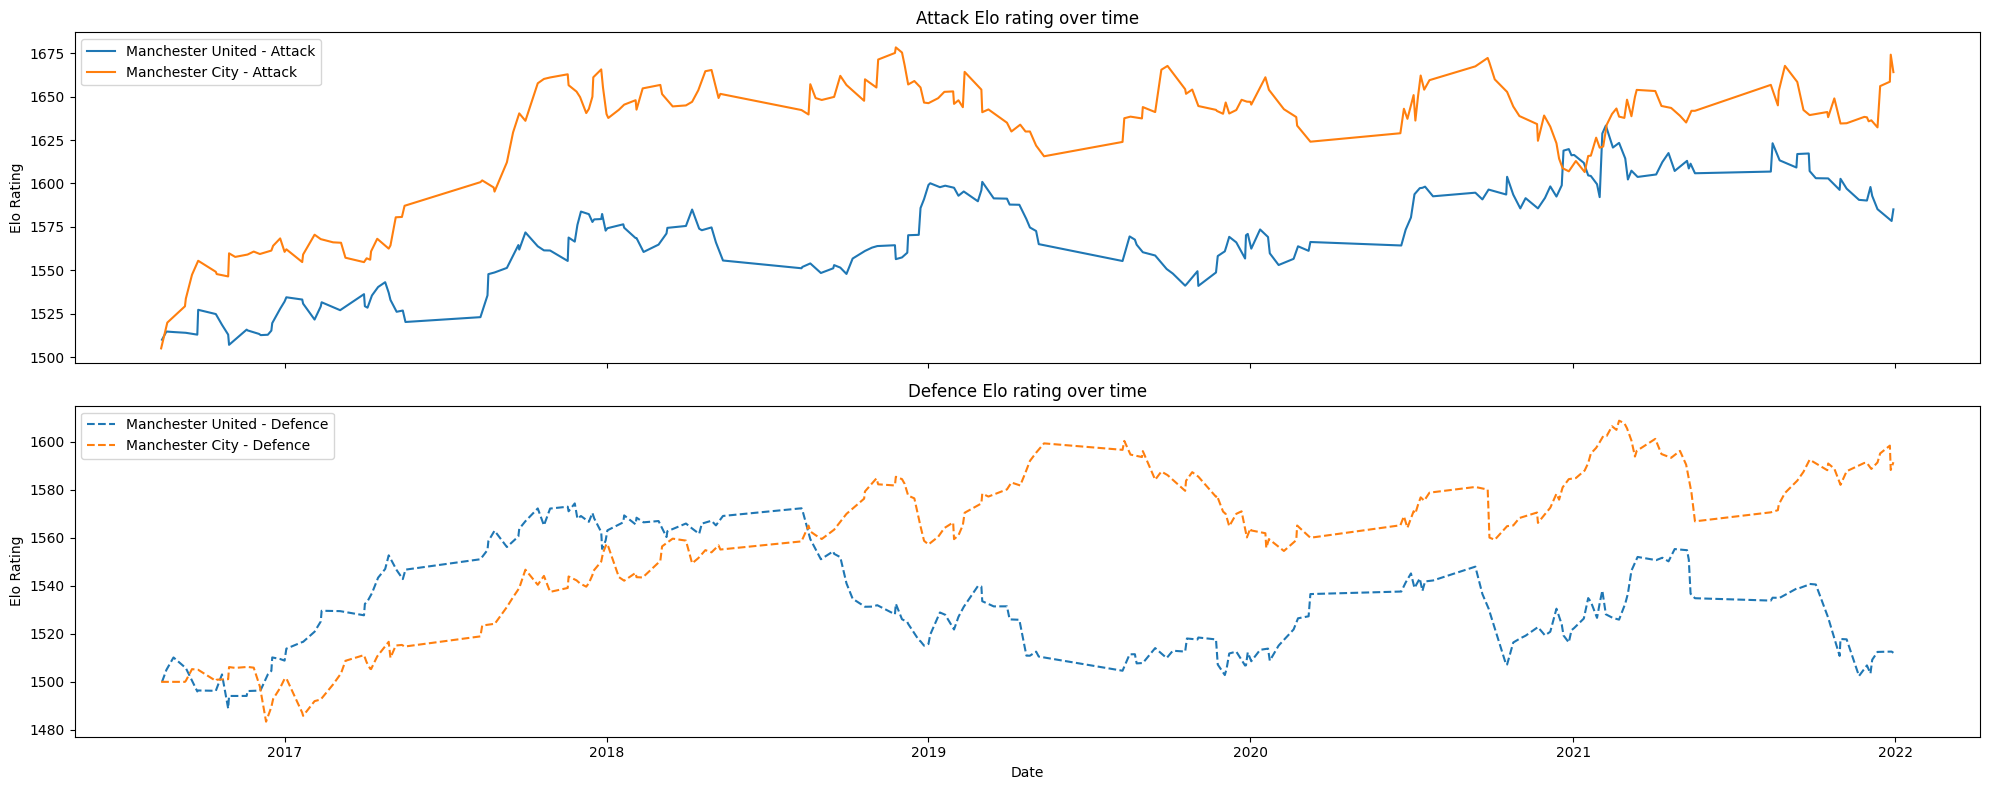

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

elo.plot(['Manchester United - Attack'], ax=ax1, color='tab:blue')
elo.plot(['Manchester City - Attack'], ax=ax1, color='tab:orange')
ax1.set(title='Attack Elo rating over time', xlabel=None)

elo.plot(['Manchester United - Defence'], ax=ax2, color='tab:blue', linestyle='--')
elo.plot(['Manchester City - Defence'], ax=ax2, color='tab:orange', linestyle='--')
ax2.set(title='Defence Elo rating over time')

fig.tight_layout()

plt.show()

## Evaluate the predictions

Calculate the Poisson deviance.

In [11]:
y_val_pred = elo.predict(X_val)
X_val['pred'] = y_val_pred
print(f'Poisson deviance is {float(mean_poisson_deviance(X_val["score"], y_val_pred)):.4f}.')

Poisson deviance is 1.2147.


And we can run simulations to determine the probabilities of a home win, draw and away win for each game.

We firstly append the expected scores to our original (validation) dataset.

In [12]:
if 'expected_goals_home' not in df_val.columns:
    df_val = pd.merge(
        df_val,
        X_val
        .pivot_table(index='game_ix', columns='home', values='pred')
        .rename(columns={0: 'expected_goals_away', 1: 'expected_goals_home'}),
        left_on='game_ix',
        right_index=True,
    )
df_val.head()

,team1,team2,prob1,prob2,probtie,score1,score2,t,game_ix,result,expected_goals_away,expected_goals_home
date,,,,,,,,,,,,
2022-01-01,Arsenal,Manchester City,0.2212,0.5526,0.2261,1,2,1640995200,2083,A,2.172179,1.003253
2022-01-01,Watford,Tottenham Hotspur,0.2450,0.5180,0.2370,0,1,1640995200,2084,A,2.145849,1.051977
2022-01-01,Crystal Palace,West Ham United,0.3235,0.4157,0.2608,2,3,1640995200,2085,A,1.953907,1.179746
2022-01-02,Leeds United,Burnley,0.4413,0.3034,0.2553,3,1,1641081600,2086,H,1.233436,1.359038
2022-01-02,Everton,Brighton and Hove Albion,0.3396,0.3782,0.2822,2,3,1641081600,2087,A,1.052798,0.925969


In [13]:
def generate_result_probas_from_poisson_expected_scores(n_simulations, expected_scores_1, expected_scores_2, random_state=None):
    if random_state is None:
        random_state = random.randint(0, 100)

    pred_probas = []
    for e1, e2 in zip(expected_scores_1, expected_scores_2):
        score_1_samples = poisson.rvs(mu=e1, size=n_simulations, random_state=random_state)
        score_2_samples = poisson.rvs(mu=e2, size=n_simulations, random_state=random_state + 1)

        results = np.where(
            score_1_samples > score_2_samples,
            1,
            np.where(
                score_1_samples == score_2_samples,
                2,
                3,
            )
        )
        result_counts = defaultdict(int, zip(*np.unique(results, return_counts=True)))
        pred_probas.append(
            [result_counts[k] / n_simulations for k in (1, 2, 3)]
        )

    return np.array(pred_probas)

In [14]:
n_simulations = 1000


result_pred_probas = generate_result_probas_from_poisson_expected_scores(
    n_simulations=n_simulations, 
    expected_scores_1=df_val['expected_goals_home'], 
    expected_scores_2=df_val['expected_goals_away'], 
    random_state=42,
)

We can now calculate the log-loss.

In [15]:
ll = log_loss(
    y_true=df_val['result'],
    y_pred=result_pred_probas,
    labels=['H', 'D', 'A'],
)
print(f"Validation set log-loss: {ll:.4f}")

Validation set log-loss: 1.3874


We can compare this to the 538 predictions, and see that the rating system above outperforms the 538 model.

In [16]:
ll = log_loss(
    y_true=df_val['result'],
    y_pred=df_val[['prob1', 'probtie', 'prob2']],
    labels=['H', 'D', 'A'],
)
print(f"538 validation set log-loss: {ll:.4f}")

538 validation set log-loss: 1.4179


/home/mike/PycharmProjects/elo-grad/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Check the calibration.

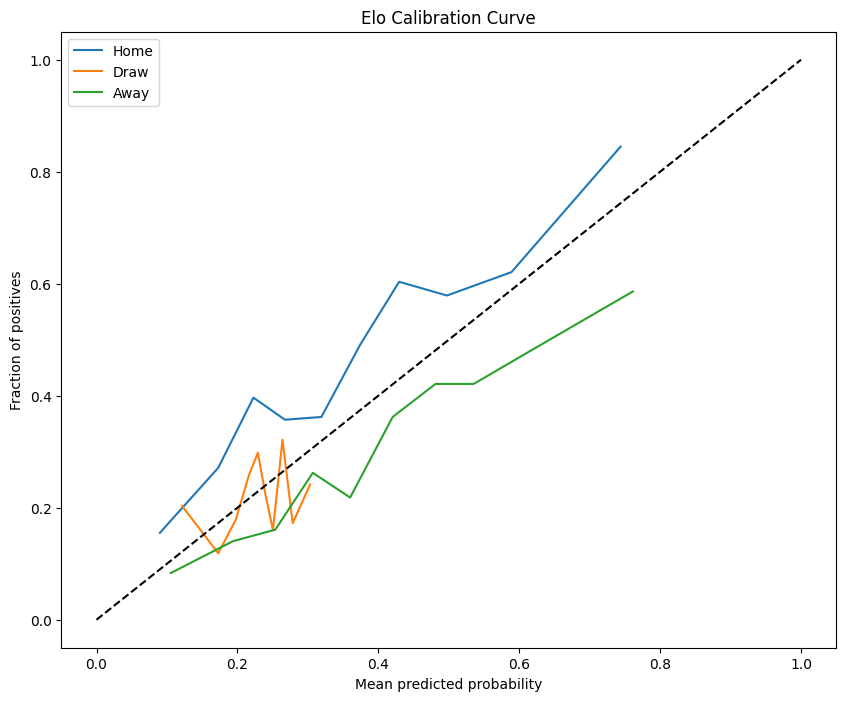

In [17]:
prob_true_home, prob_pred_home = calibration_curve([a == 'H' for a in df_val['result']], result_pred_probas[:, 0], n_bins=10, strategy='quantile')
prob_true_draw, prob_pred_draw = calibration_curve([a == 'D' for a in df_val['result']], result_pred_probas[:, 1], n_bins=10, strategy='quantile')
prob_true_away, prob_pred_away = calibration_curve([a == 'A' for a in df_val['result']], result_pred_probas[:, 2], n_bins=10, strategy='quantile')

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(prob_pred_home, prob_true_home, label='Home')
ax.plot(prob_pred_draw, prob_true_draw, label='Draw')
ax.plot(prob_pred_away, prob_true_away, label='Away')

ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set(
    title='Elo Calibration Curve',
    xlabel='Mean predicted probability',
    ylabel='Fraction of positives',
)
ax.legend()

plt.show()

## Grid search

`elo-grad` also offers the `scikit-learn` estimator `SKPoissonEloEstimator`.
We can then use `scikit-learn` to do things like perform a grid search over hyper-parameters.

In [18]:
gs = GridSearchCV(
    estimator=SKPoissonEloEstimator(
        entity_cols=('team', 'opponent'), 
        score_col='score', 
        init_ratings={'intercept': (None, 0)}, 
        additional_regressors=[Regressor(name='intercept', k_factor=0.1)],
    ), 
    param_grid={
        'beta': [200],
        'k_factor': [10, 50],
    },
    cv=TimeSeriesSplit(n_splits=3),
)
gs.fit(X_train, X_train['score'])
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_beta,param_k_factor,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.027597,0.007262,0.011630,0.002617,200,10,"{'beta': 200, 'k_factor': 10}",1.163520,1.213899,1.214095,1.197172,0.023795,2
1,0.016626,0.005177,0.011277,0.000706,200,50,"{'beta': 200, 'k_factor': 50}",2.930513,2.180070,2.220247,2.443610,0.344683,1


## Home advantage

We can add an additional regressor to capture the effect of home advantage.
We use a smaller scale factor and set the initial rating to `30` for this additional regressor.

In [19]:
elo_home = PoissonEloEstimator(
    entity_cols=('team', 'opponent'), 
    score_col='score', 
    date_col='t',
    beta=200, 
    k_factor=5, 
    default_init_rating=1500,
    init_ratings={'intercept': (None, 0), 'home': (None, 30)},
    additional_regressors=[Regressor(name='intercept', k_factor=1e-4), Regressor(name='home', k_factor=1e-2)],
    track_rating_history=True,
)

home_preds = elo_home.fit(X_train)
sorted(elo_home.model.ratings.items(), key=lambda item: item[1][1], reverse=True)[:10]

[('Manchester City - Attack', (1640822400, 1656.4671122837929)),
 ('Liverpool - Attack', (1640736000, 1627.2307433457377)),
 ('Manchester City - Defence', (1640822400, 1599.5192881398427)),
 ('Chelsea - Attack', (1640822400, 1593.9052232471233)),
 ('Leicester City - Attack', (1640736000, 1592.4776950596474)),
 ('West Ham United - Attack', (1640736000, 1584.36024080199)),
 ('Arsenal - Attack', (1640563200, 1583.3443160549655)),
 ('Manchester United - Attack', (1640822400, 1578.5356676483395)),
 ('Chelsea - Defence', (1640822400, 1569.8377677309086)),
 ('Liverpool - Defence', (1640736000, 1567.1209175598106))]

We see that adding this regressor reduces the Poisson deviance but increases the log-loss.
It's possible that this different direction of movement in the metrics is due to us not accounting for correlation in the scores,
though this would need to be investigated further.

In [20]:
y_val_home_pred = elo_home.predict(X_val)
X_val['home_pred'] = y_val_home_pred
print(f'Poisson deviance is {float(mean_poisson_deviance(X_val["score"], y_val_home_pred)):.4f}.')

Poisson deviance is 1.1955.


In [21]:
if 'expected_goals_home_2' not in df_val.columns:
    df_val = pd.merge(
        df_val,
        X_val
        .pivot_table(index='game_ix', columns='home', values='home_pred')
        .rename(columns={0: 'expected_goals_away_2', 1: 'expected_goals_home_2'}),
        left_on='game_ix',
        right_index=True,
    )
df_val.head()

,team1,team2,prob1,prob2,probtie,score1,score2,t,game_ix,result,expected_goals_away,expected_goals_home,expected_goals_away_2,expected_goals_home_2
date,,,,,,,,,,,,,,
2022-01-01,Arsenal,Manchester City,0.2212,0.5526,0.2261,1,2,1640995200,2083,A,2.172179,1.003253,1.969128,1.087759
2022-01-01,Watford,Tottenham Hotspur,0.2450,0.5180,0.2370,0,1,1640995200,2084,A,2.145849,1.051977,1.962488,1.154207
2022-01-01,Crystal Palace,West Ham United,0.3235,0.4157,0.2608,2,3,1640995200,2085,A,1.953907,1.179746,1.784541,1.269258
2022-01-02,Leeds United,Burnley,0.4413,0.3034,0.2553,3,1,1641081600,2086,H,1.233436,1.359038,1.131315,1.466740
2022-01-02,Everton,Brighton and Hove Albion,0.3396,0.3782,0.2822,2,3,1641081600,2087,A,1.052798,0.925969,0.951973,0.999836


In [22]:
result_pred_probas_home = generate_result_probas_from_poisson_expected_scores(
    n_simulations=n_simulations, 
    expected_scores_1=df_val['expected_goals_home_2'], 
    expected_scores_2=df_val['expected_goals_away_2'], 
    random_state=42,
)

ll = log_loss(
    y_true=df_val['result'],
    y_pred=result_pred_probas_home,
    labels=['H', 'D', 'A'],
)
print(f"Validation set log-loss: {ll:.4f}")

Validation set log-loss: 1.4164


And we can look at the calibration again.

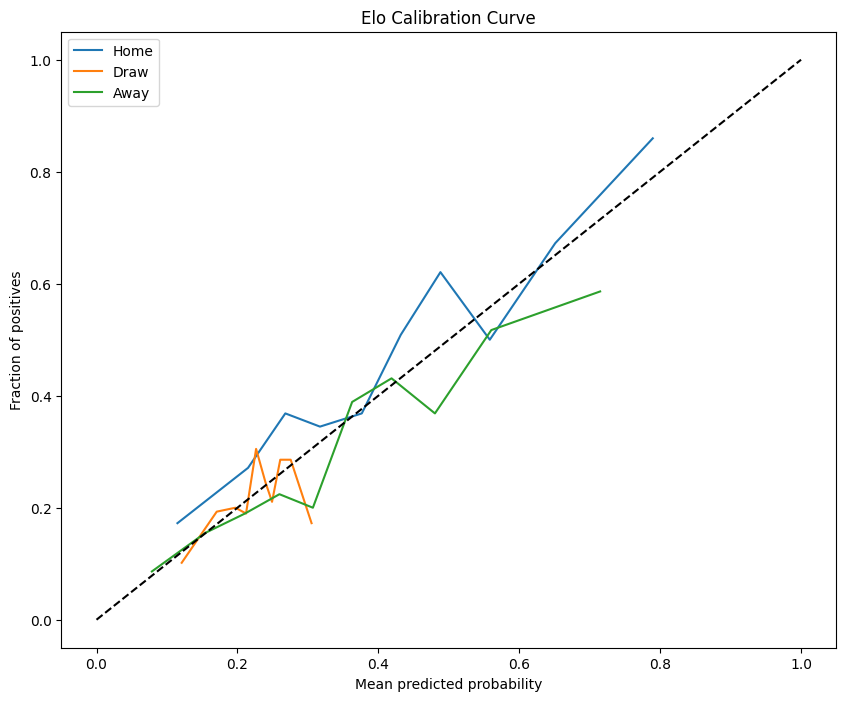

In [23]:
prob_true_home, prob_pred_home = calibration_curve([a == 'H' for a in df_val['result']], result_pred_probas_home[:, 0], n_bins=10, strategy='quantile')
prob_true_draw, prob_pred_draw = calibration_curve([a == 'D' for a in df_val['result']], result_pred_probas_home[:, 1], n_bins=10, strategy='quantile')
prob_true_away, prob_pred_away = calibration_curve([a == 'A' for a in df_val['result']], result_pred_probas_home[:, 2], n_bins=10, strategy='quantile')

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(prob_pred_home, prob_true_home, label='Home')
ax.plot(prob_pred_draw, prob_true_draw, label='Draw')
ax.plot(prob_pred_away, prob_true_away, label='Away')

ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set(
    title='Elo Calibration Curve',
    xlabel='Mean predicted probability',
    ylabel='Fraction of positives',
)
ax.legend()

plt.show()

We can also visualise the home advantage effect over time.

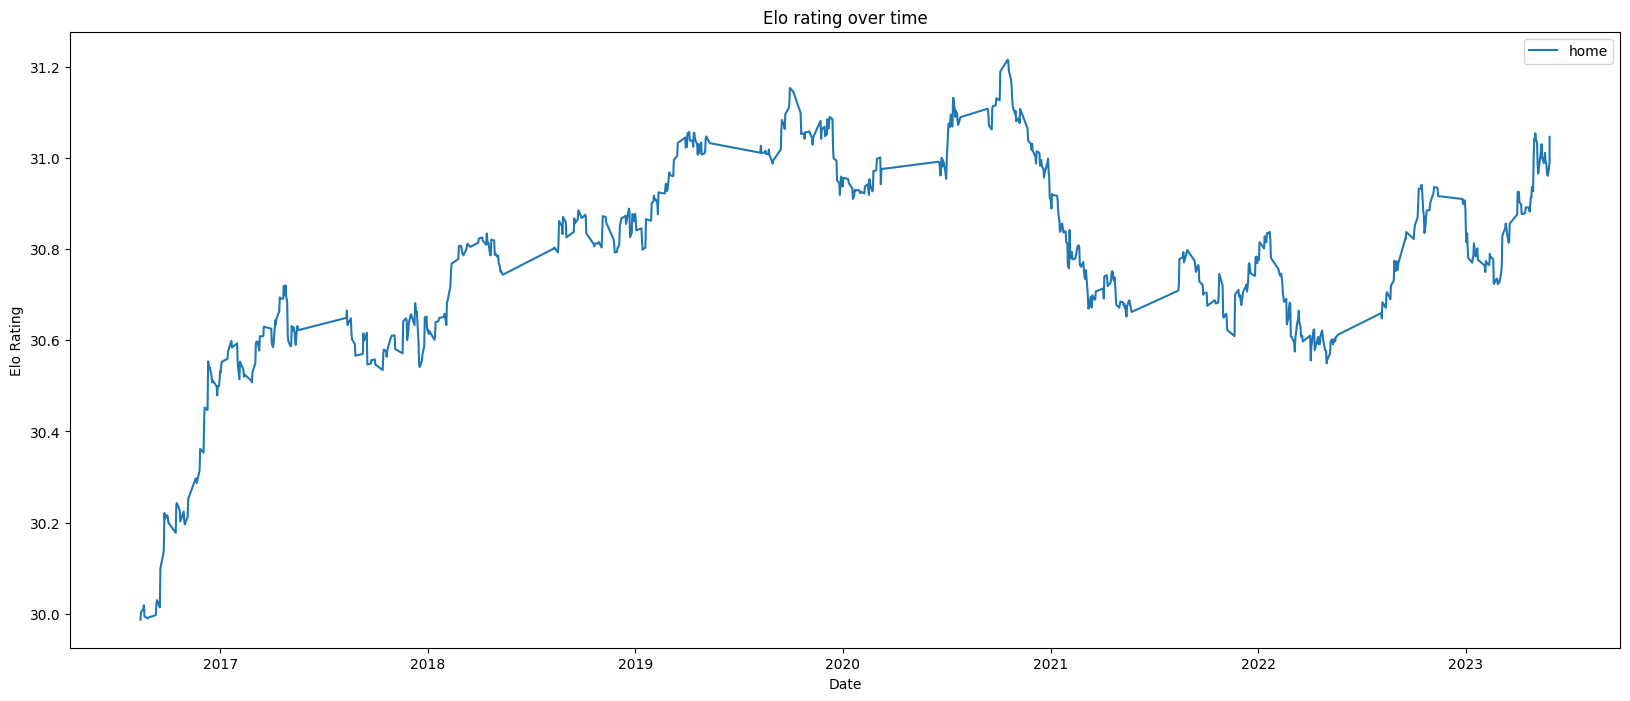

In [24]:
fig, ax = plt.subplots(figsize=(20, 8))
elo_home.plot(['home'], ax=ax)
plt.show()

It's easier to see the intercept on a separate scale.

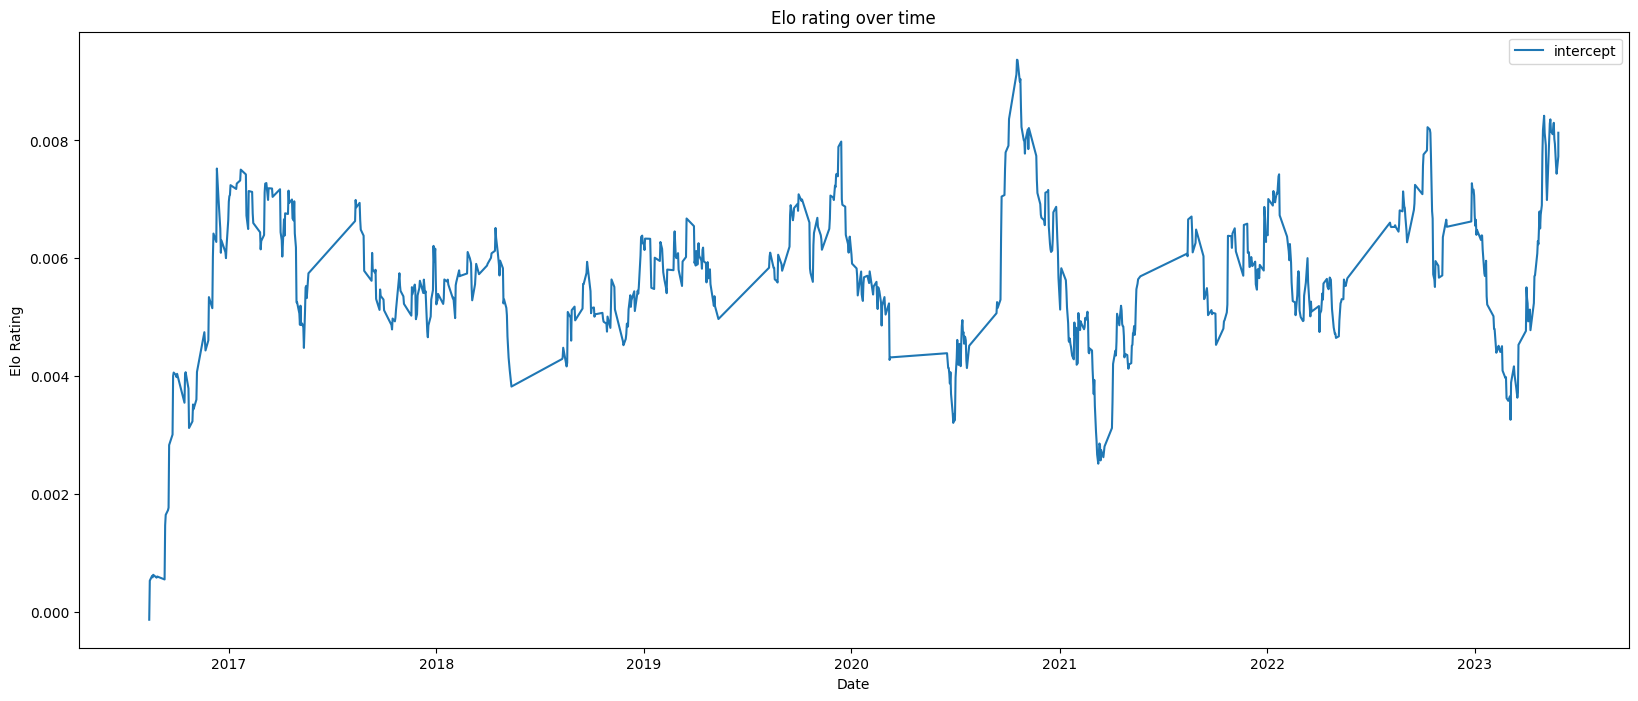

In [25]:
fig, ax = plt.subplots(figsize=(20, 8))
elo_home.plot(['intercept'], ax=ax)
plt.show()

Finally, let's benchmark performance when we add in home advantage.

In [27]:
%%timeit -n 20
elo = PoissonEloEstimator(
    entity_cols=('team', 'opponent'), 
    score_col='score', 
    beta=200, 
    k_factor=5, 
    default_init_rating=1500,
    init_ratings={'intercept': (None, 0), 'home': (None, 30)},
    additional_regressors=[Regressor(name='intercept', k_factor=1e-4), Regressor(name='home', k_factor=1e-2)],
)

elo.fit(X_train)

42.3 ms ± 3.89 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)
